# Probando el tutorial de segmentación

In [2]:
# Importamos librerías
import skimage.io
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np

# Elegimos directorio de guardado de imagen 
dirpath = "C:/Users/cdedi/Desktop/Sample/"

# Generamos una función de carga de cada una de las secciones en las que se encuentran las células en la imagen y sus nombres
def loader(x,vector,names_vector):
    for i in range(4,11,1):
        if i < 10:
            img_now = skimage.io.imread(dirpath + "T00001C0" + str(x) + "Z00" + str(i) + ".tif")
        if i >= 10:
            img_now = skimage.io.imread(dirpath + "T00001C0" + str(x) + "Z0" + str(i) + ".tif")
        vector[i-4] = img_now[(855-12):(855+12),(547-12):(547+12)]
        if i < 10:
            names_vector[i-4] = "T00001C0" + str(x) + "Z00" + str(i) + ".tif"
        if i >= 10:
            names_vector[i-4] = "T00001C0" + str(x) + "Z0" + str(i) + ".tif"

In [3]:
# Se generan vectores para cada una de las imágenes y de sus canales y se cargan las imágenes en ellas

red_vector = [0] * 7
white_vector = [0] * 7
blue_vector = [0] * 7
red_names = [0] * 7
white_names = [0] * 7
blue_names = [0] * 7

loader(1, red_vector, red_names)
loader(2, white_vector, white_names)
loader(3, blue_vector, blue_names)

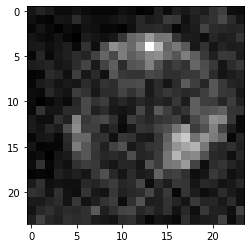

In [4]:
# Se muestra una de las imágenes
plt.imshow(red_vector[3], cmap = "gray")

In [5]:
# Guardamos las secciones de las células 
def saver(vector, names_vector):
    for i in range(0,7,1):
        skimage.io.imsave("C:/Users/cdedi/Desktop/Cropped/" + names_vector[i], vector[i])
    
saver(red_vector, red_names)
saver(white_vector, white_names)
saver(blue_vector, blue_names)

<ipython-input-5-199da0faac47>:3: UserWarning: C:/Users/cdedi/Desktop/Cropped/T00001C03Z004.tif is a low contrast image
  skimage.io.imsave("C:/Users/cdedi/Desktop/Cropped/" + names_vector[i], vector[i])
<ipython-input-5-199da0faac47>:3: UserWarning: C:/Users/cdedi/Desktop/Cropped/T00001C03Z005.tif is a low contrast image
  skimage.io.imsave("C:/Users/cdedi/Desktop/Cropped/" + names_vector[i], vector[i])
<ipython-input-5-199da0faac47>:3: UserWarning: C:/Users/cdedi/Desktop/Cropped/T00001C03Z009.tif is a low contrast image
  skimage.io.imsave("C:/Users/cdedi/Desktop/Cropped/" + names_vector[i], vector[i])


### Red channel

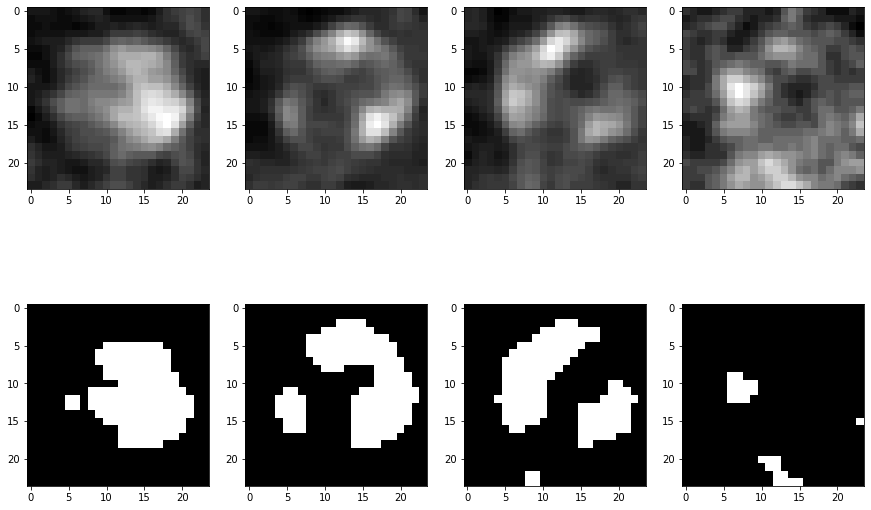

In [31]:
# Aplicamos un filtro gaussiano a cada capa y hacemos un threshold manual
img_gauss_minus1 = ndi.gaussian_filter(red_vector[2],1)
img_gauss_manual_minus1 = img_gauss_minus1 > 21
img_gauss = ndi.gaussian_filter(red_vector[3],1)
img_gauss_manual = img_gauss > 21
img_gauss2 = ndi.gaussian_filter(red_vector[4],1)
img_gauss_manual2 = img_gauss2 > 21
img_gauss3 = ndi.gaussian_filter(red_vector[5],1)
img_gauss_manual3 = img_gauss3 > 21


plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
plt.imshow(img_gauss_minus1, cmap="gray")

plt.subplot(2,4,2)
plt.imshow(img_gauss, cmap="gray")

plt.subplot(2,4,3)
plt.imshow(img_gauss2, cmap="gray")

plt.subplot(2,4,4)
plt.imshow(img_gauss3, cmap="gray")

plt.subplot(2,4,5)
plt.imshow(img_gauss_manual_minus1, cmap="gray")

plt.subplot(2,4,6)
plt.imshow(img_gauss_manual, cmap="gray")

plt.subplot(2,4,7)
plt.imshow(img_gauss_manual2, cmap="gray")

plt.subplot(2,4,8)
plt.imshow(img_gauss_manual3, cmap="gray")

El threshold puede ser convincente, pero deja parte de la última sección y conllevaría una segmentación muy subjetiva y dependiente de la imagen; por tanto, descartamos este método de segmentación.

Además, debido a la gran posibilidad de segmentar background y no célula en la última sección, decidimos trabajar sólo con las tres primeras a partir de ahora.

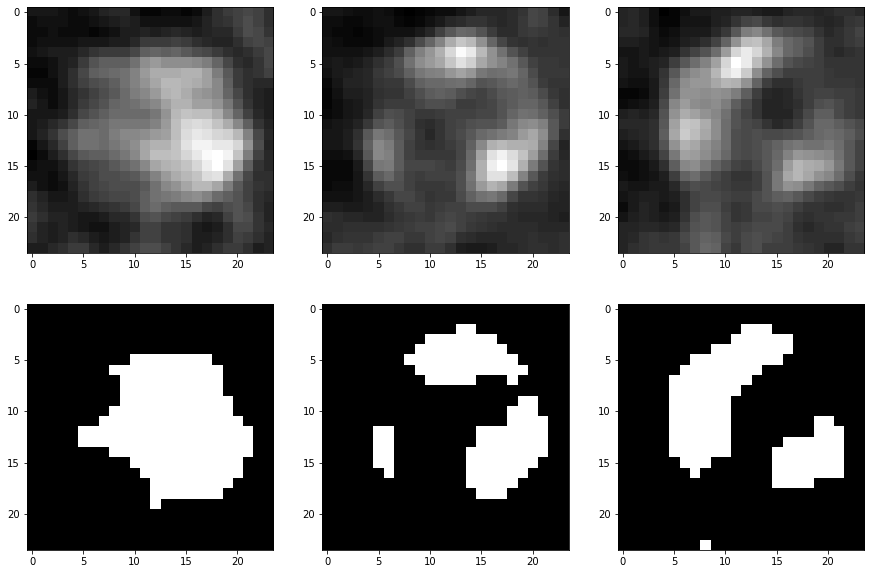

In [32]:
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu


# Realizamos un threshold automático (threshold de Otsu) y lo aplicamos a cada capa. Visualizamos.
img_gauss_minus1 = ndi.gaussian_filter(red_vector[2],1)
otsu_minus1 = threshold_otsu(img_gauss_minus1)
img_gauss_otsu_minus1 = img_gauss_minus1 > otsu_minus1 
img_gauss = ndi.gaussian_filter(red_vector[3],1)
otsu1 = threshold_otsu(img_gauss)
img_gauss_otsu1 = img_gauss > otsu1 
img_gauss2 = ndi.gaussian_filter(red_vector[4],1)
otsu2 = threshold_otsu(img_gauss2)
img_gauss_otsu2 = img_gauss2 > otsu2 


plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(img_gauss_minus1, cmap="gray")

plt.subplot(2,3,2)
plt.imshow(img_gauss, cmap="gray")

plt.subplot(2,3,3)
plt.imshow(img_gauss2, cmap="gray")

plt.subplot(2,3,4)
plt.imshow(img_gauss_otsu_minus1, cmap="gray")

plt.subplot(2,3,5)
plt.imshow(img_gauss_otsu1, cmap="gray")

plt.subplot(2,3,6)
plt.imshow(img_gauss_otsu2, cmap="gray")

El threshold parece bueno pero es mejorable (sobre todo en la primera imagen). Intentaremos mejorar la segmentación por máximos locales y por watershed

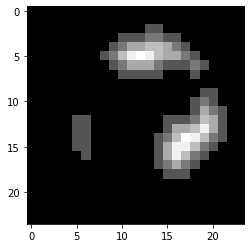

In [39]:
# Creando un mapa de distancias para poder aplicar máximos locales
used_layers_threshold_vector = (img_gauss_otsu_minus1,img_gauss_otsu1,img_gauss_otsu2)
distance_threshold_vector = [0] * len(used_layers_threshold_vector)

for i in range(0,len(used_layers_threshold_vector),1):
    distance_threshold_vector[i] = ndi.distance_transform_edt(used_layers_threshold_vector[i])
    
plt.imshow(distance_threshold_vector[1],cmap="gray")

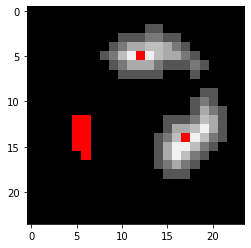

In [10]:
# Detectando cada uno de los máximos locales
from skimage.feature import peak_local_max
seeds_vector = [0] * len(distance_threshold_vector)

for i in range(0,len(distance_threshold_vector),1):
    seeds_vector[i] = peak_local_max(distance_threshold_vector[i], indices=False, min_distance=5)

# Create plot
plt.imshow(distance_threshold_vector[1], interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_vector[1], mask=seeds_vector[1]==0), interpolation='none', cmap='autumn')
plt.show()

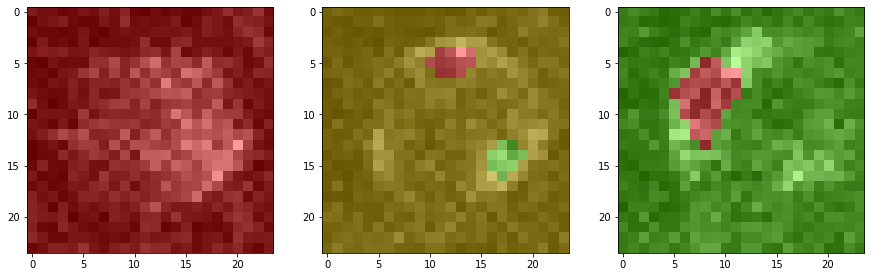

In [12]:
# Aplicamos un algoritmo de watershed
from skimage.segmentation import watershed
watershed_vector = [0] * len(seeds_labeled_vector)

for i in range(0,len(seeds_vector),1):
    watershed_vector[i] = watershed(used_layers_threshold_vector[i], seeds_labeled_vector[i])
    
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(red_vector[2], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[0], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,2)
plt.imshow(red_vector[3], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[1], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,3)
plt.imshow(red_vector[4], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[2], interpolation='none', cmap='prism', alpha=0.4)

Como podemos observar, el uso de watershed no sólo no mejora sino que empeora la segmentación. Por tanto, lo siguiente que probaremos son operaciones morfológicas.

Los canales azul y blanco tampoco se segmentan de manera adecuada, por lo que decidimos omitirlos en las siguientes pruebas de segmentación

### White channel

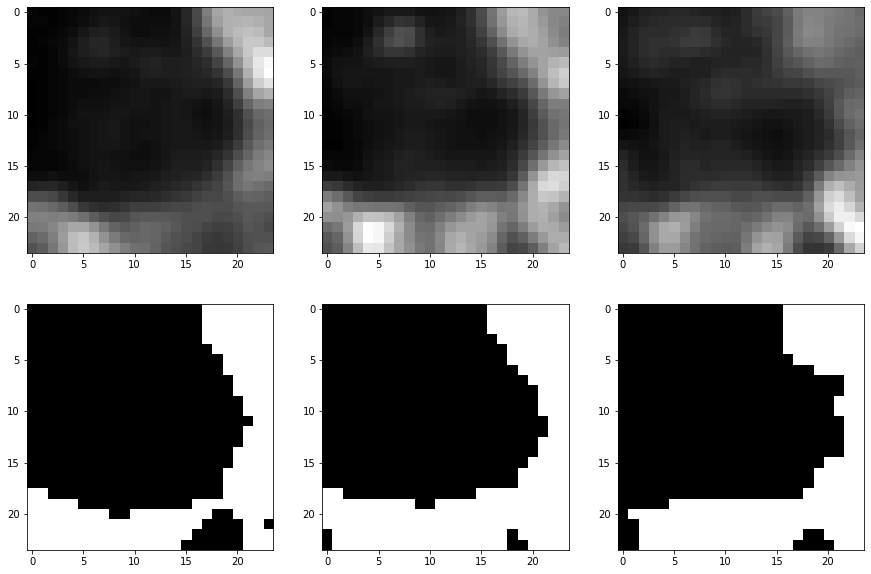

In [13]:
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu

img_gauss_minus1 = ndi.gaussian_filter(white_vector[2],1)
otsu_minus1 = threshold_otsu(img_gauss_minus1)
img_gauss_otsu_minus1 = img_gauss_minus1 > otsu_minus1 
img_gauss = ndi.gaussian_filter(white_vector[3],1)
otsu1 = threshold_otsu(img_gauss)
img_gauss_otsu1 = img_gauss > otsu1 
img_gauss2 = ndi.gaussian_filter(white_vector[4],1)
otsu2 = threshold_otsu(img_gauss2)
img_gauss_otsu2 = img_gauss2 > otsu2 


plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(img_gauss_minus1, cmap="gray")

plt.subplot(2,3,2)
plt.imshow(img_gauss, cmap="gray")

plt.subplot(2,3,3)
plt.imshow(img_gauss2, cmap="gray")

plt.subplot(2,3,4)
plt.imshow(img_gauss_otsu_minus1, cmap="gray")

plt.subplot(2,3,5)
plt.imshow(img_gauss_otsu1, cmap="gray")

plt.subplot(2,3,6)
plt.imshow(img_gauss_otsu2, cmap="gray")

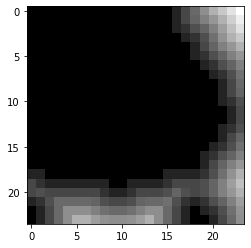

In [14]:
used_layers_threshold_vector = (img_gauss_otsu_minus1,img_gauss_otsu1,img_gauss_otsu2)
distance_threshold_vector = [0] * len(used_layers_threshold_vector)

for i in range(0,len(used_layers_threshold_vector),1):
    distance_threshold_vector[i] = ndi.distance_transform_edt(used_layers_threshold_vector[i])
    
plt.imshow(distance_threshold_vector[1],cmap="gray")

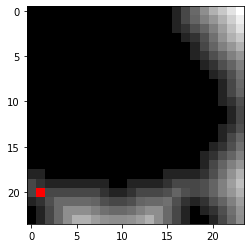

In [15]:
from skimage.feature import peak_local_max
seeds_vector = [0] * len(distance_threshold_vector)

for i in range(0,len(distance_threshold_vector),1):
    seeds_vector[i] = peak_local_max(distance_threshold_vector[i], indices=False, min_distance=1)

# Create plot
plt.imshow(distance_threshold_vector[1], interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_vector[1], mask=seeds_vector[1]==0), interpolation='none', cmap='autumn')
plt.show()

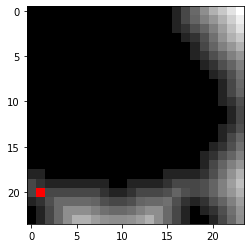

In [16]:
seeds_labeled_vector = [0] * len(distance_threshold_vector)

for i in range(0,len(seeds_vector),1):
    seeds_labeled_vector[i] = ndi.label(seeds_vector[i])[0]
    
plt.imshow(distance_threshold_vector[1], interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_vector[1], mask=seeds_vector[1]==0), interpolation='none', cmap='prism')
plt.show()    

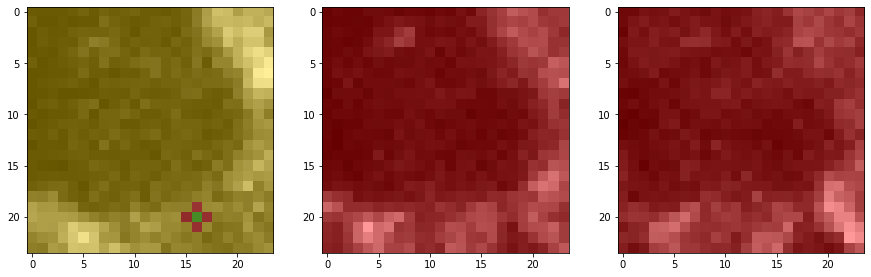

In [17]:
from skimage.segmentation import watershed
watershed_vector = [0] * len(seeds_labeled_vector)

for i in range(0,len(seeds_vector),1):
    watershed_vector[i] = watershed(used_layers_threshold_vector[i], seeds_labeled_vector[i],watershed_line = True)
    
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(white_vector[2], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[0], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,2)
plt.imshow(white_vector[3], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[1], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,3)
plt.imshow(white_vector[4], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[2], interpolation='none', cmap='prism', alpha=0.4)

### Blue channel

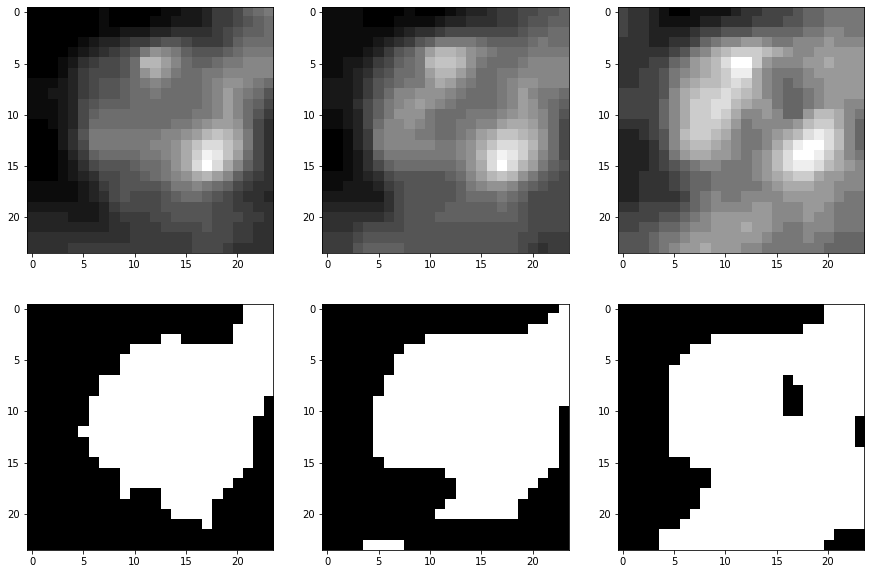

In [18]:
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu

img_gauss_minus1 = ndi.gaussian_filter(blue_vector[2],0.25)
otsu_minus1 = threshold_otsu(img_gauss_minus1)
img_gauss_otsu_minus1 = img_gauss_minus1 > otsu_minus1 
img_gauss = ndi.gaussian_filter(blue_vector[3],0.25)
otsu1 = threshold_otsu(img_gauss)
img_gauss_otsu1 = img_gauss > otsu1 
img_gauss2 = ndi.gaussian_filter(blue_vector[4],0.25)
otsu2 = threshold_otsu(img_gauss2)
img_gauss_otsu2 = img_gauss2 > otsu2 


plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(img_gauss_minus1, cmap="gray")

plt.subplot(2,3,2)
plt.imshow(img_gauss, cmap="gray")

plt.subplot(2,3,3)
plt.imshow(img_gauss2, cmap="gray")

plt.subplot(2,3,4)
plt.imshow(img_gauss_otsu_minus1, cmap="gray")

plt.subplot(2,3,5)
plt.imshow(img_gauss_otsu1, cmap="gray")

plt.subplot(2,3,6)
plt.imshow(img_gauss_otsu2, cmap="gray")

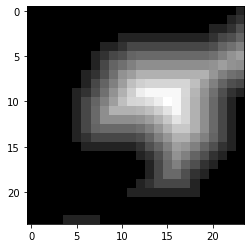

In [19]:
used_layers_threshold_vector = (img_gauss_otsu_minus1,img_gauss_otsu1,img_gauss_otsu2)
distance_threshold_vector = [0] * len(used_layers_threshold_vector)

for i in range(0,len(used_layers_threshold_vector),1):
    distance_threshold_vector[i] = ndi.distance_transform_edt(used_layers_threshold_vector[i])
    
plt.imshow(distance_threshold_vector[1],cmap="gray")

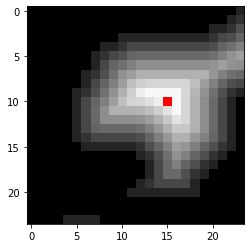

In [20]:
from skimage.feature import peak_local_max
seeds_vector = [0] * len(distance_threshold_vector)

for i in range(0,len(distance_threshold_vector),1):
    seeds_vector[i] = peak_local_max(distance_threshold_vector[i], indices=False, min_distance=5)

# Create plot
plt.imshow(distance_threshold_vector[1], interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_vector[1], mask=seeds_vector[1]==0), interpolation='none', cmap='autumn')
plt.show()

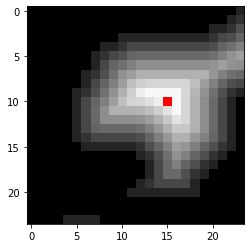

In [21]:
seeds_labeled_vector = [0] * len(distance_threshold_vector)

for i in range(0,len(seeds_vector),1):
    seeds_labeled_vector[i] = ndi.label(seeds_vector[i])[0]
    
plt.imshow(distance_threshold_vector[1], interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_vector[1], mask=seeds_vector[1]==0), interpolation='none', cmap='prism')
plt.show()    

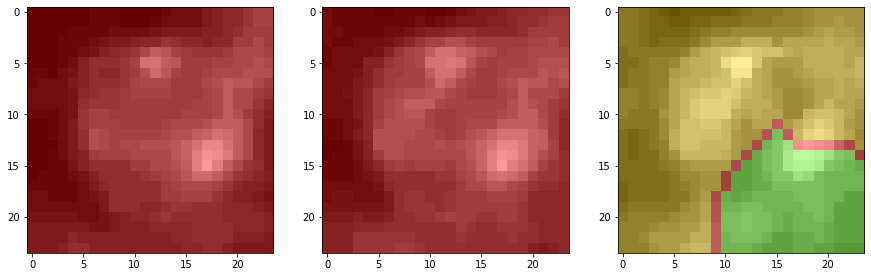

In [22]:
from skimage.segmentation import watershed
watershed_vector = [0] * len(seeds_labeled_vector)

for i in range(0,len(seeds_vector),1):
    watershed_vector[i] = watershed(used_layers_threshold_vector[i], seeds_labeled_vector[i],watershed_line = True)
    
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(blue_vector[2], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[0], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,2)
plt.imshow(blue_vector[3], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[1], interpolation='none', cmap='prism', alpha=0.4)

plt.subplot(1,3,3)
plt.imshow(blue_vector[4], interpolation='none', cmap='gray')
plt.imshow(watershed_vector[2], interpolation='none', cmap='prism', alpha=0.4)